# ОИАД. Лабораторная работа №1

Используйте набор данных 'datasets/teen_phone_addiction_dataset.csv'. 

Возьмите столбец $N \% 7 $, где $N$ - номер в списке группы (см. ниже).

## I. 
Рассчитайте характеристики:
1. Среднее
2. Дисперсия
3. Мода
4. Медиана
5. Квантили уровня 0.25, 0.5, 0.75
6. Эксцесс
7. Ассиметрия
8. Интерквартильный размах

Построить графики:
1. Гистограмма
2. Эмпирическая функция распределения

## II. 
Проверить данные на нормальность, используя критерии:
1. Хи-квадрат (Реализовать самому, не используя библиотечные варианты!!)
2. Ассиметрии и эксцесса

Построить Q-Q plot

## III. 
Используя техники обработки данных, постарайтесь привести данные к нормальному распределению.  Например, с помощью:
1. Удаление, усечение выбросов
2. Стандартизация, нормировка
3. Логарифмирование и т.п.

Выполните пункты I и II для обработанных данных

## IV.
Сгруппируйте данные по столбцу 'School_Grade'. 

1. На одном графике постройте гистограммы для каждой группы.
2. Рассчитайте среднее, дисперсию внутри каждой группы

## V.
После каждого пункта сделайте промежуточные выводы:
1. Опишите полученные числовые характеристики и графики
2. Являются ли данные нормальными
3. Эффект от обработки данных (удалось ли привести данные к нормальному виду)
4. Различия распределений внутри разных групп 'School_Grade'




In [1]:
N = 11
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
cols[N % 7]

'Time_on_Social_Media'

# Решение

## Пункт 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("../../datasets/teen_phone_addiction_dataset.csv")
col = cols[N % 7]
data_col = data[col].to_numpy()

In [3]:
def mean(data):
    return np.mean(data)

def var(data):
    return np.mean((data - mean(data)) ** 2)

def mode(data):
    nbins = 1 + int(np.log2(data.shape[0]))
    hist, bins = np.histogram(data, bins=nbins)
    pos = np.argmax(hist)
    x = bins[pos]
    h = bins[1] - bins[0]
    prev = hist[pos - 1] if pos > 0 else 0
    next = hist[pos + 1] if pos + 1 < nbins else 0
    return x + h * (bins[pos] - prev) / (2 * bins[pos] - prev - next)

def quantile(data, q):
    assert 0.0 <= q <= 1.0
    nbins = 1 + int(np.log2(data.shape[0]))
    hist, bins = np.histogram(data, bins=nbins)
    chist = np.cumsum(hist)
    ids = (chist < q * data.shape[0]).astype(int)
    ok = ids.nonzero()[0]
    pos = ok[-1] + 1 if np.size(ok) > 0 else 0
    x = bins[pos]
    h = bins[1] - bins[0]
    prev = chist[pos - 1] if pos > 0 else 0
    return x + h * (q * data.shape[0] - prev) / hist[pos]

def kurtosis(data):
    num = np.mean((data - mean(data)) ** 4)
    den = var(data) ** 2
    return num / den - 3.0

def skewness(data):
    num = np.mean((data - mean(data)) ** 3)
    den = var(data) ** 1.5
    return num / den

def interquartile_range(data):
    return quantile(data, 0.75) - quantile(data, 0.25)

In [4]:
def plot_hist(data, **kwargs):
    nbins = 1 + int(np.log2(data.shape[0]))
    hist, bins = np.histogram(data, bins=nbins)
    plt.hist(data, bins, edgecolor="black", **kwargs)
    plt.show()

def plot_cdf(data, **kwargs):
    sdata = np.sort(data)
    plt.plot(sdata, np.arange(data.shape[0]) / data.shape[0], **kwargs)
    plt.show()

In [5]:
params = {
    "среднее": (mean, {}),
    "дисперсия": (var, {}),
    "мода": (mode, {}),
    "медиана": (quantile, {"q": 0.5}),
    "Q(0.25)": (quantile, {"q": 0.25}),
    "Q(0.5)": (quantile, {"q": 0.5}),
    "Q(0.75)": (quantile, {"q": 0.75}),
    "эксцесс": (kurtosis, {}),
    "асимметрия": (skewness, {}),
    "интерквартильный размах": (interquartile_range, {})
}

for k, v in params.items():
    print(f"{k + ':':30}{v[0](data_col, **v[1])}")

среднее:                      2.4992333333333336
дисперсия:                    0.9762160788888888
мода:                         2.7251506024096384
медиана:                      2.538265306122449
Q(0.25):                      1.83969769291965
Q(0.5):                       2.538265306122449
Q(0.75):                      3.151041666666667
эксцесс:                      -0.21487391248537868
асимметрия:                   0.06693949989874562
интерквартильный размах:      1.311343973747017


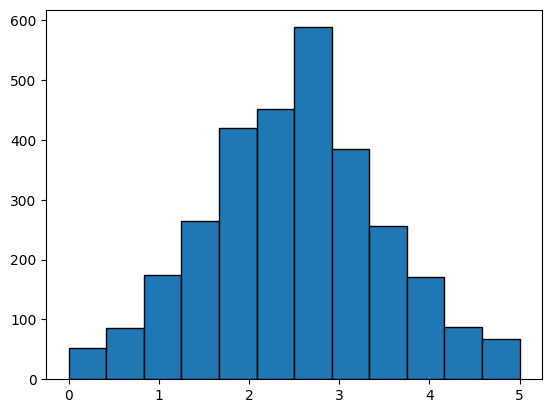

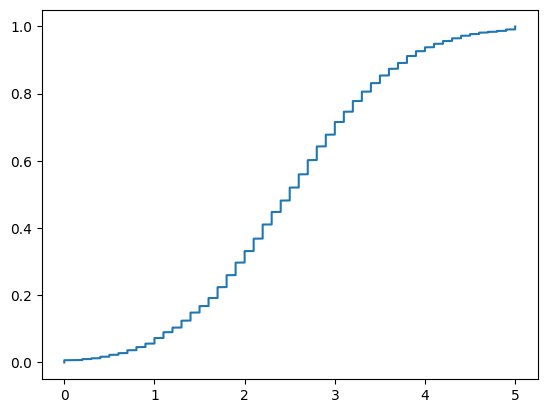

In [6]:
plot_hist(data_col)
plot_cdf(data_col)

## Пункт 2

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, probplot
import json

data = pd.read_csv("../../datasets/teen_phone_addiction_dataset.csv")
col = cols[N % 7]
data_col = data[col].to_numpy()

In [8]:
def chi2_test(data, alpha = 0.05):
    mu, sigma = data.mean(), data.std()
    nbins = 1 + int(np.log2(data.shape[0]))
    hist, bins = np.histogram(data, bins=nbins)

    expected = np.zeros_like(hist)
    for i in range(nbins):
        expected[i] = (norm.cdf(bins[i + 1], loc=mu, scale=sigma) - norm.cdf(bins[i], loc=mu, scale=sigma)) * data.shape[0]
    df = nbins - 1 - 2 # еще вычли количество параметров
    stat = np.sum(((hist - expected) ** 2) / expected)

    return {
        "значение": stat,
        f"порог для alpha={alpha}": chi2.ppf(1 - alpha, df),
        "p-value": 1.0 - chi2.cdf(stat, df),
        "ожидаемое": expected.tolist(),
        "наблюдаемое": hist.tolist(),
        "слагаемые": ((hist - expected) ** 2 / expected).tolist()
    }

In [9]:
print(json.dumps(chi2_test(data_col), indent=4, ensure_ascii=False))

{
    "значение": 70.10728558309947,
    "порог для alpha=0.05": 16.918977604620448,
    "p-value": 1.450684017356707e-11,
    "ожидаемое": [
        35,
        85,
        171,
        289,
        411,
        490,
        490,
        411,
        289,
        171,
        84,
        35
    ],
    "наблюдаемое": [
        52,
        86,
        174,
        264,
        419,
        451,
        588,
        384,
        256,
        171,
        87,
        68
    ],
    "слагаемые": [
        8.257142857142858,
        0.011764705882352941,
        0.05263157894736842,
        2.162629757785467,
        0.15571776155717762,
        3.1040816326530614,
        19.6,
        1.7737226277372262,
        3.7681660899653977,
        0.0,
        0.10714285714285714,
        31.114285714285714
    ]
}


In [10]:
kurtosis(data_col), skewness(data_col)

(np.float64(-0.21487391248537868), np.float64(0.06693949989874562))

In [11]:
6/data_col.shape[0], 24/data_col.shape[0]

(0.002, 0.008)

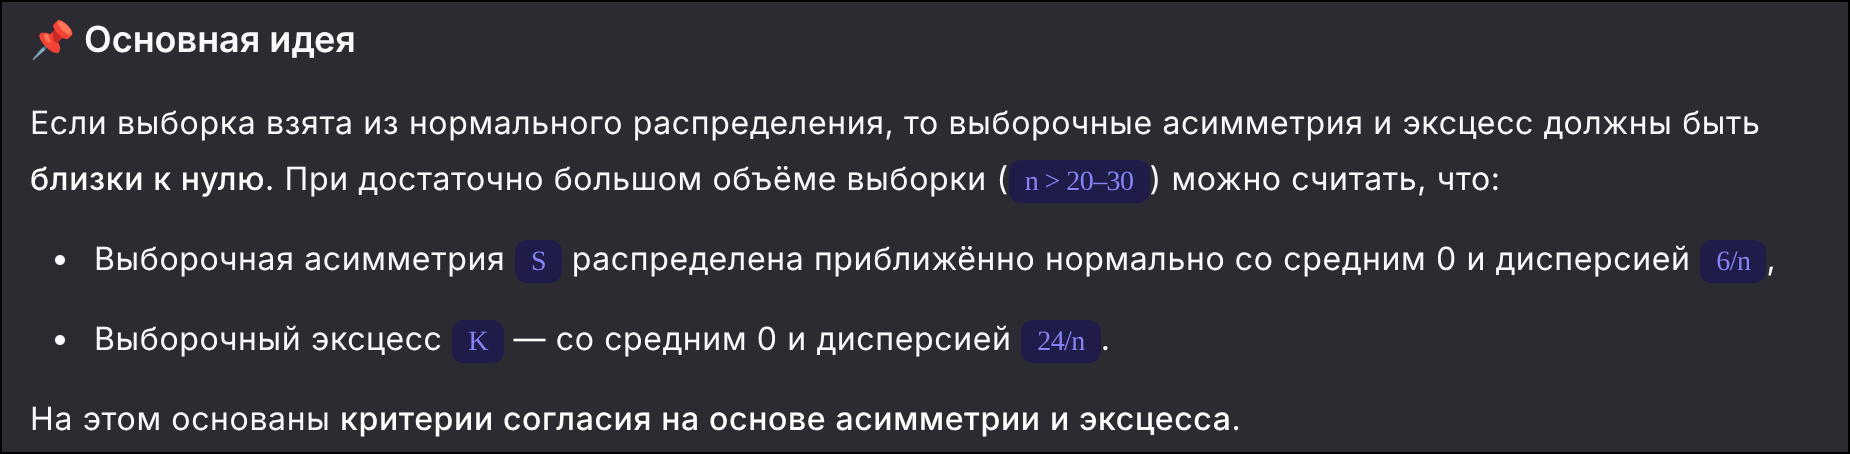

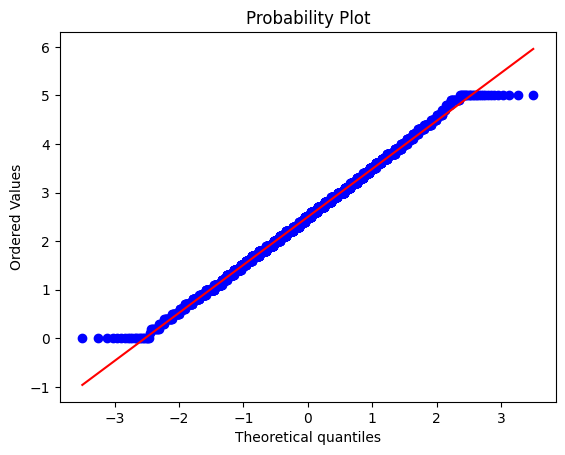

In [12]:
probplot(data_col, dist="norm", plot=plt)
plt.show()

- хи-квадрат говорит, что не нормальное  
  если присмотреться, то помимо выброса посередине есть слишком тяжелые хвосты
- эксцесс и кривизна тоже
- на Q-Q plot проблемы с хвостами

## Пункт 3

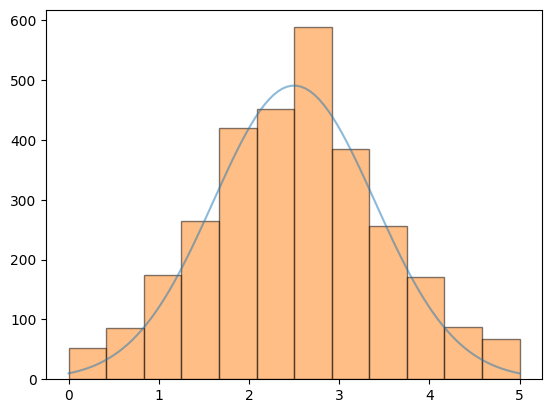

In [13]:
# попытка натянуть сову на глобус

x = np.linspace(0, 5, 100)
mu = 2.5
sigma = 0.8
y = np.exp(-(x - mu) ** 2 / (2 * sigma)) / np.sqrt(2 * np.pi * sigma) * 1100

plt.plot(x, y, alpha=0.5)
plot_hist(data_col, alpha=0.5)

в целом выглядит как нормальное + мусор

In [14]:
# Рубим по квантилям
p = 0.001
low = quantile(data_col, p)
high = quantile(data_col, 1.0 - p)

print(low, high)
data_col_clean = data_col[(low <= data_col) & (data_col <= high)]

0.02403846153846154 4.981617647058824


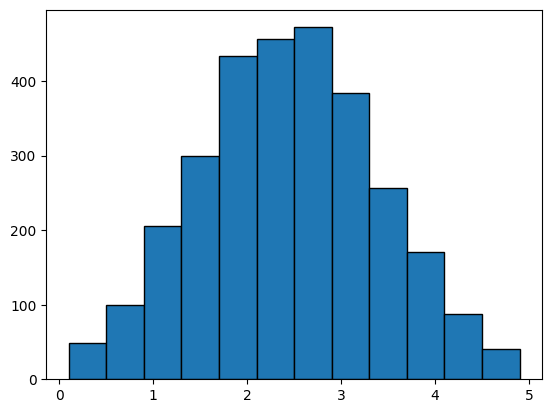

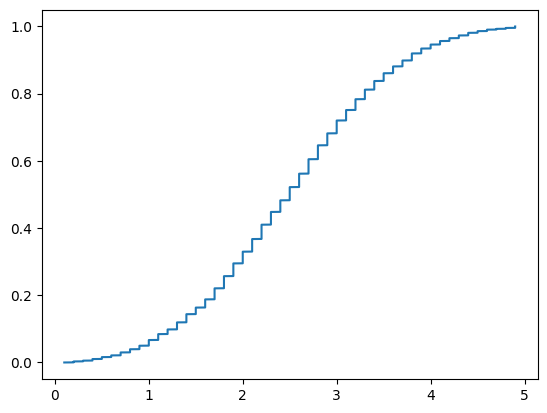

In [15]:
plot_hist(data_col_clean)
plot_cdf(data_col_clean)

In [16]:
params = {
    "среднее": (mean, {}),
    "дисперсия": (var, {}),
    "мода": (mode, {}),
    "медиана": (quantile, {"q": 0.5}),
    "Q(0.25)": (quantile, {"q": 0.25}),
    "Q(0.5)": (quantile, {"q": 0.5}),
    "Q(0.75)": (quantile, {"q": 0.75}),
    "эксцесс": (kurtosis, {}),
    "асимметрия": (skewness, {}),
    "интерквартильный размах": (interquartile_range, {})
}

for k, v in params.items():
    print(f"{k + ':':30}{v[0](data_col_clean, **v[1])}")

среднее:                      2.494139566395664
дисперсия:                    0.8904297474588907
мода:                         2.7172455089820367
медиана:                      2.4429824561403515
Q(0.25):                      1.7794457274826794
Q(0.5):                       2.4429824561403515
Q(0.75):                      3.109375000000001
эксцесс:                      -0.39811927308979245
асимметрия:                   0.05621141162362226
интерквартильный размах:      1.3299292725173215


In [17]:
print(json.dumps(chi2_test(data_col_clean), indent=4, ensure_ascii=False))

{
    "значение": 27.299168212833926,
    "порог для alpha=0.05": 16.918977604620448,
    "p-value": 0.0012479107127648659,
    "ожидаемое": [
        34,
        83,
        169,
        286,
        407,
        485,
        484,
        404,
        283,
        166,
        81,
        33
    ],
    "наблюдаемое": [
        48,
        100,
        205,
        299,
        433,
        456,
        472,
        384,
        256,
        171,
        87,
        41
    ],
    "слагаемые": [
        5.764705882352941,
        3.4819277108433737,
        7.668639053254438,
        0.5909090909090909,
        1.660933660933661,
        1.734020618556701,
        0.2975206611570248,
        0.9900990099009901,
        2.5759717314487633,
        0.15060240963855423,
        0.4444444444444444,
        1.9393939393939394
    ]
}


получше, но недостаточно

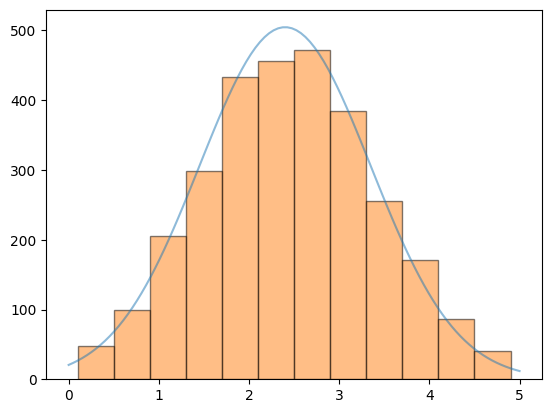

In [21]:
# вторая попытка натянуть сову на глобус

x = np.linspace(0, 5, 100)
mu = 2.4
sigma = 0.9
y = np.exp(-(x - mu) ** 2 / (2 * sigma)) / np.sqrt(2 * np.pi * sigma) * 1200

plt.plot(x, y, alpha=0.5)
plot_hist(data_col_clean, alpha=0.5)

распределение слишком тупое, чтобы быть нормальным  
но при этом выглядит до боли нормальным

## Пункт 4

In [22]:
data["School_Grade"].value_counts()

School_Grade
12th    529
9th     526
7th     497
10th    487
8th     482
11th    479
Name: count, dtype: int64

In [37]:
d = dict()

for v in sorted(data["School_Grade"].unique()):
    d[v] = data.loc[data["School_Grade"] == v][col]

In [38]:
stats = dict()

for k, v in d.items():
    stats[k] = {
        "mean": v.mean(),
        "var": v.var()
    }

In [39]:
print(json.dumps(stats, indent=4))

{
    "10th": {
        "mean": 2.5240246406570837,
        "var": 0.9227343862228644
    },
    "11th": {
        "mean": 2.487891440501044,
        "var": 0.9458781806587993
    },
    "12th": {
        "mean": 2.4638941398865786,
        "var": 1.0139779887724123
    },
    "7th": {
        "mean": 2.5400402414486924,
        "var": 0.91958306289349
    },
    "8th": {
        "mean": 2.469917012448133,
        "var": 1.0303821136808688
    },
    "9th": {
        "mean": 2.510456273764259,
        "var": 1.025966648560565
    }
}


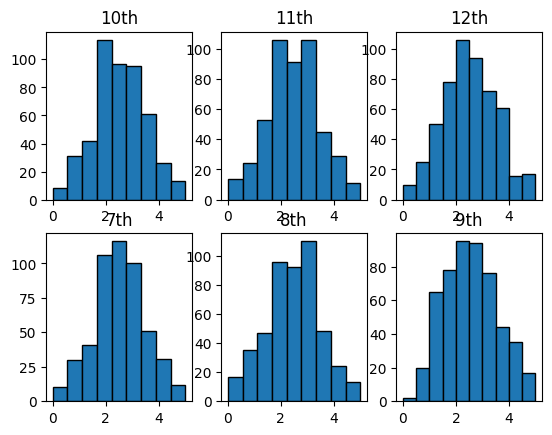

In [50]:
def histplot(data, where, title):
    nbins = 1 + int(np.log2(data.shape[0]))
    hist, bins = np.histogram(data, bins=nbins)
    where.hist(data, bins, edgecolor="black")
    where.set_title(title)

fig, ax = plt.subplots(2, 3)
for pos, k in enumerate(d.keys()):
    i = pos // 3
    j = pos % 3
    histplot(d[k], ax[i,j], k)

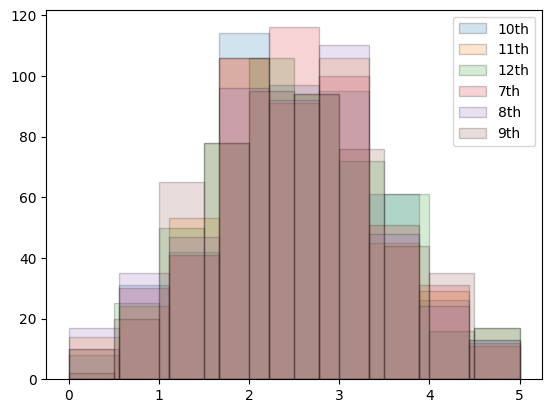

In [54]:
for pos, k in enumerate(d.keys()):
    i = pos // 3
    j = pos % 3
    nbins = 1 + int(np.log2(d[k].shape[0]))
    hist, bins = np.histogram(d[k], bins=nbins)
    plt.hist(d[k], bins, edgecolor="black", label=k, alpha=0.2)
plt.legend()
plt.show()

- отличаются пики
- отличается острота пика
- отличается асимметрия